# (01) Load & process input data

**Input files of this notebook:**
* `'../config.yml'`
* file as defined in study_area_polygon path variable in '../config.yml'


**Output files of this notebook:**
* `'../data/grid_{study_area}.gpkg'`
* `'../data/osm_{study_area}.graphml'`
* `'../data/osm_{study_area}_simple.graphml'`
* `'../data/osm_meta_{study_area}.json'`
* `'../data/ref_{study_area}.graphml'`
* `'../data/ref_{study_area}_simple.graphml'`
* `'../data/reference_meta_{study_area}.json'`



**Overview**

This notebook loads the polygon defining the study area and then creates a grid overlay (with grid cell size as defined in `config.yml`) for the study area. Then, we download the data for the study area from OpenStreetMap using OSMnx, and retain only the features of cycling infrastructure (with queries as defined in `config.yml`). Then, we classify each edge of the cycling infrastructure network according to three attributes: protected/unprotected; bidirectional/unidirectional; and centerline/individual geometry. The same process is applied to the reference data set, if provided. Output files of this notebook (full and simplified graphs and metadata for both OSM and reference data sets; and the grid layer of the study area) are saved to the `../data` subfolder and used in the notebooks 02 and 03.

**Sections:**

1. Load data for study area & define grid
2. Load OSM data
3. Load reference data (if applicable)

***

## 1. Load data for study area & define grid

In this step we:
* Load settings for the analysis from the config file
* Read in data for the study area
* Create a grid overlay of the study area, with grid cell size defined in the config file

In [1]:
import geopandas as gpd
import osmnx as ox
import networkx as nx 
import yaml
import matplotlib.pyplot as plt
import contextily as cx
from datetime import datetime
import json
from src import evaluation_functions as ef
from src import matching_functions as mf
from src import simplification_functions_new as sf
from src import graph_functions as gf

**Load settings for analysis:**

In [2]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    use_custom_filter = parsed_yaml_file['use_custom_filter']
    custom_filter = parsed_yaml_file['custom_filter']
    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']
    osm_cycling_infrastructure_type = parsed_yaml_file['osm_cycling_infrastructure_type']
    osm_way_tags = parsed_yaml_file['osm_way_tags']

    reference_comparison = parsed_yaml_file['reference_comparison']
    reference_fp = parsed_yaml_file['reference_fp']
    reference_geometries = parsed_yaml_file['reference_geometries']
    cycling_bidirectional = parsed_yaml_file['bidirectional']
    ref_cycling_infrastructure_type = parsed_yaml_file['ref_cycling_infrastructure_type']
    reference_id_col = parsed_yaml_file['reference_id_col']

    grid_cell_size = parsed_yaml_file['grid_cell_size']

    
print('Settings loaded!')

ef.check_settings_validity(
    study_area, 
    study_area_poly_fp, 
    study_crs, 
    use_custom_filter, 
    custom_filter, 
    reference_comparison,
    reference_fp, 
    reference_geometries, 
    cycling_bidirectional, 
    grid_cell_size
    )


Settings loaded!


### Read in data for study area

The size of the study area is 181.38 square kilometers


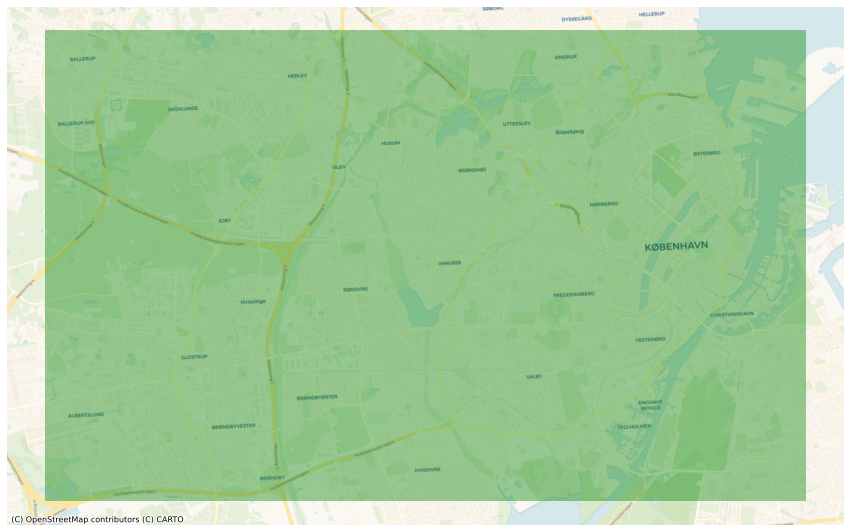

In [3]:
# Read polygon for study area
study_area_poly = gpd.read_file(study_area_poly_fp)

if study_area_poly.crs == None:
    print('Please assign a crs to the study area polygon!')

if study_area_poly.crs != study_crs:
    study_area_poly = study_area_poly.to_crs(study_crs)

assert study_area_poly.crs == study_crs

area = study_area_poly.area.values[0]
print(f'The size of the study area is {area / 1000000:.2f} square kilometers')

fig, ax = plt.subplots(1, figsize=(15,15))

study_area_poly.plot(ax=ax, color='green', alpha=0.4)

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager)

### Create grid to be used in the analysis

/opt/miniconda3/envs/cdq/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


The grid contains 770 cells


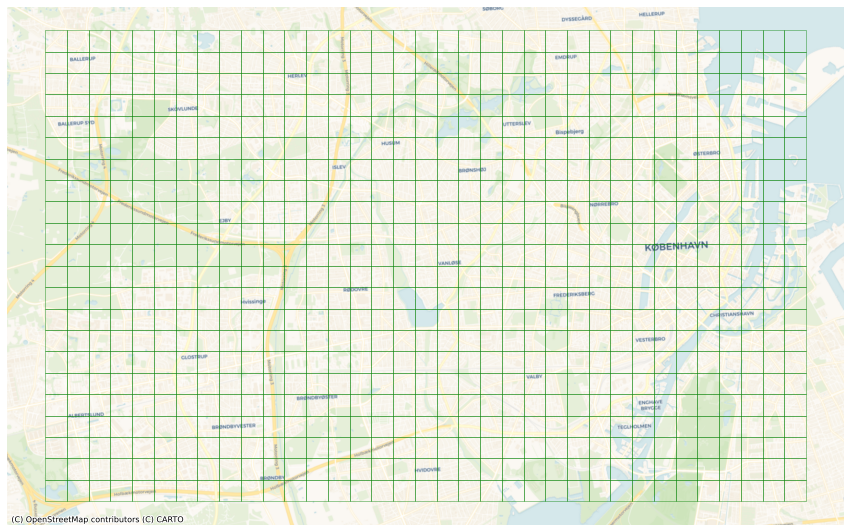

In [4]:
grid = ef.create_grid_geometry(study_area_poly, grid_cell_size)

grid['grid_id'] = grid.index

grid.to_file(f'../data/grid_{study_area}.gpkg')

fig, ax = plt.subplots(1, figsize=(15,15))

print(f'The grid contains {len(grid)} cells')

grid.plot(ax=ax, facecolor='none', edgecolor='green', alpha=0.4)

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager)

## 2. Load OSM data

In this step we:
- Download data from OpenStreetMap using OSMnx
- Project the data to the chosen CRS
- Create a subnetwork consisting only of cycling infrastructure
- Classify all edges in the cycling network based on whether they are protected or unprotected cycling infrastructure, how they have been digitised, and whether they allow for bidirectional travel or not
- Simplify the network *(to read more about the modified OSMnx simplification (Boeing, 2017) used here, we refer to this [Github repository](https://github.com/anerv/NERDS_osmnx) which contains both the simplification functions, explanation of the logic and a demonstration)*

Depending on the size of your study area, getting data through OSMnx can take a little while.

In [6]:

ox.utils.config(use_cache=False, 
    useful_tags_way = osm_way_tags)

graph_osm = ox.graph_from_polygon(
    study_area_poly.to_crs('EPSG:4326').loc[0, 'geometry'], 
    network_type='bike', 
    simplify=False, 
    retain_all=True, 
    truncate_by_edge=False, 
    clean_periphery=True
    )

print('Data retrieved!')    

# Project graph to chosen crs
graph_osm = ox.project_graph(graph_osm, to_crs=study_crs)

# Get osm_edges and osm_nodes
osm_nodes, osm_edges = ox.graph_to_gdfs(graph_osm)

# Clean up column names (removing ':' and upper case letters)
osm_edges = gf.clean_col_names(osm_edges)
osm_nodes = gf.clean_col_names(osm_nodes)

# Add attribute on whether cycling infra exist or not (to be used by e.g. simplification function)
osm_edges['cycling_infrastructure'] = 'no'

for q in cycling_infrastructure_queries.values():

    try:
        ox_filtered = osm_edges.query(q)

    except Exception:
        print('Exception occured when quering with:', q)

    osm_edges.loc[ox_filtered.index, 'cycling_infrastructure'] = 'yes'

osm_edges.cycling_infrastructure.value_counts()

cycling_edges = osm_edges.loc[osm_edges.cycling_infrastructure == 'yes'].copy()

# If the new subset of edges contains edges with 1 as a key, but no corresponding edge with 0 as a key, change the key to 0
cycling_edges = ef.fix_key_index(cycling_edges)

# Define whether cycling infrastructure is in both or one direction and whether it is one- or bidirectional
cycling_edges = ef.simplify_cycling_tags(cycling_edges)

# Classify edges as protected or unprotected
cycling_edges = ef.define_protected_unprotected(cycling_edges, osm_cycling_infrastructure_type)

cycling_graph, cycling_nodes = ef.create_cycling_network(cycling_edges, osm_nodes, graph_osm, return_nodes=True)
print('Created network only with cycling infrastructure!')

# Simplify cycling network
cycling_graph_simplified = sf.momepy_simplify_graph(
    cycling_graph, 
    attributes=[
        'cycling_infrastructure',
        'cycling_bidirectional',
        'cycling_geometries',
        'protected'
        ]
    )

# Get undirected network representation
cycling_graph_simplified = ox.get_undirected(cycling_graph_simplified)
cycling_graph = ox.get_undirected(cycling_graph)

cycling_nodes_simplified, cycling_edges_simplified = ox.graph_to_gdfs(cycling_graph_simplified, nodes=True)

# Measure the length of cycling infrastructure (!=from length of edges)
cycling_edges_simplified['length'] = cycling_edges_simplified.geometry.length
cycling_edges_simplified['infrastructure_length'] = cycling_edges_simplified.apply(
    lambda x: ef.measure_infrastructure_length(
        edge = x.geometry, 
        geometry_type=x.cycling_geometries, 
        bidirectional=x.cycling_bidirectional, 
        cycling_infrastructure=x.cycling_infrastructure), 
    axis=1)

# Creating coulumns with unique feature id (required by some functions)
cycling_edges['edge_id'] = cycling_edges.reset_index().index
cycling_edges_simplified['edge_id'] = cycling_edges_simplified.reset_index().index

osm_id_dict = cycling_edges['edge_id'].to_dict()
nx.set_edge_attributes(cycling_graph, osm_id_dict, 'edge_id')

osm_id_dict_s = cycling_edges_simplified['edge_id'].to_dict()
nx.set_edge_attributes(cycling_graph_simplified, osm_id_dict_s, 'edge_id')

cycling_nodes['node_id'] = cycling_nodes.reset_index().index
cycling_nodes_simplified['node_id'] = cycling_nodes_simplified.reset_index().index

osm_id_dict = cycling_nodes['node_id'].to_dict()
nx.set_node_attributes(cycling_graph, osm_id_dict, 'node_id')

osm_id_dict_s = cycling_nodes_simplified['node_id'].to_dict()
nx.set_node_attributes(cycling_graph_simplified, osm_id_dict_s, 'node_id')

# Saving data to graphs
osm_l_dict = osm_edges['length'].to_dict()
nx.set_edge_attributes(cycling_graph, osm_l_dict, 'length')

osm_l_dict_s = cycling_edges_simplified['length'].to_dict()
nx.set_edge_attributes(cycling_graph_simplified, osm_l_dict_s, 'length')

osm_il_dict = cycling_edges_simplified['infrastructure_length'].to_dict()
nx.set_edge_attributes(cycling_graph_simplified, osm_il_dict, 'infrastructure_length')

# Overview of data from OSM
graph_area = ef.get_graph_area(cycling_nodes, study_area_poly, study_crs)
print(f'The graph covers an area of {graph_area/ 1000000:.2f} square kilometers')

print(f'The length of the OSM network with cycling infrastructure is {cycling_edges_simplified.infrastructure_length.sum()/1000 :.2f} kilometers')

Data retrieved!
Bidirectional Value Counts: 
 False    32226
True     17465
Name: cycling_bidirectional, dtype: int64
Geometry Type Value Counts: 
 centerline         25491
true_geometries    24200
Name: cycling_geometries, dtype: int64
Protected Value Counts: 
 protected      45276
unprotected     3791
mixed            624
Name: protected, dtype: int64
Created network only with cycling infrastructure!
The graph covers an area of 179.70 square kilometers
The length of the OSM network with cycling infrastructure is 1064.63 kilometers


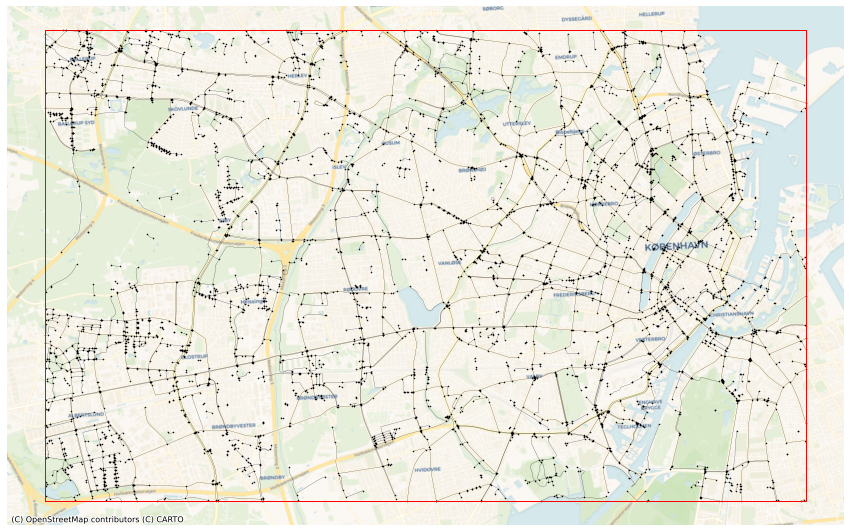

In [7]:
# Plot network
fig, ax = plt.subplots(1, figsize=(15,15))

cycling_edges_simplified.plot(ax=ax, color='black', linewidth=0.2)
cycling_nodes_simplified.plot(ax=ax, color='black', markersize=0.3)

study_area_poly.plot(ax=ax, edgecolor='red', facecolor='None', linewidth=1)

cx.add_basemap(
    ax=ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager
)
ax.set_axis_off()

In [8]:
# Save data
ox.save_graphml(cycling_graph, f'../data/osm_{study_area}.graphml')
ox.save_graphml(cycling_graph_simplified, f'../data/osm_{study_area}_simple.graphml')
print('OSM networks saved!')

data_load_dict = {}

# Save time for when OSM data was loaded
current_time = datetime.now().strftime('%m/%d/%Y, %H:%M:%S')
data_load_dict['data_retrieved_at'] = current_time

# Save results of simplifying network
data_load_dict['nodes_removed_during_simplification'] = len(cycling_nodes) - len(cycling_nodes_simplified)
data_load_dict['edges_removed_during_simplification'] = len(cycling_edges) - len(cycling_edges_simplified)

with open(f'../data/osm_meta_{study_area}.json', 'w') as outfile:
    json.dump(data_load_dict, outfile)

OSM networks saved!


## 3. Load reference data

In this step we:
- Create a network from the reference data
- Project it to the chosen CRS
- Clip the data to the polygon defining the study area
- Measure the infrastructure length the edges based on the geometry type and whether they allow for bidirectional travel or not
- Simplify the network

The reference data covers an area of 169.76 square kilometers
Protected Value Counts: 
 protected      8438
unprotected    2130
Name: protected, dtype: int64
The length of the reference network is 623.52 kilometers
Reference networks saved!


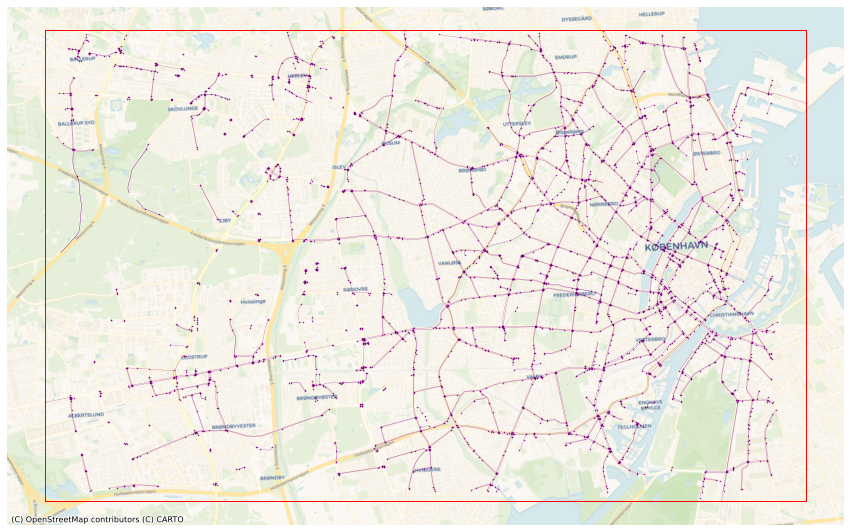

In [9]:
if reference_comparison:

    # Read reference data
    ref_data = gpd.read_file(reference_fp)

    # Create column with id called 'osmid'
    ref_data['osmid'] = ref_data[reference_id_col]

    # Reproject
    if ref_data.crs == None:
        print('Please assign a crs to the study area polygon!')

    if ref_data.crs != study_crs:
        ref_data = ref_data.to_crs(study_crs)

    assert ref_data.crs == study_crs

    # Clip reference data to study area poly
    ref_data = ref_data.clip(study_area_poly)

    # Convert to osmnx graph object
    graph_ref = gf.create_osmnx_graph(ref_data)

    ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)

    # Overview of data
    graph_area = ef.get_graph_area(ref_nodes, study_area_poly, study_crs)
    print(f'The reference data covers an area of {graph_area / 1000000:.2f} square kilometers')

    # Classify edges as protected or unprotected
    ref_edges = ef.define_protected_unprotected(ref_edges, ref_cycling_infrastructure_type)

    # Recreate graph with updated data
    graph_ref = gf.create_osmnx_graph(ref_edges)

    # Simplify - the graph is simplified as much as possible, but without combining edges with conflicting values of cycling infrastructure types
    graph_ref_simple = sf.momepy_simplify_graph(graph_ref, attributes=['vejklasse','protected'])

    graph_ref = ox.get_undirected(graph_ref)
    ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)
    graph_ref_simple = ox.get_undirected(graph_ref_simple)

    ref_nodes_simplified, ref_edges_simplified = ox.graph_to_gdfs(graph_ref_simple)

    ref_edges['length'] = ref_edges.geometry.length
    ref_edges_simplified['length'] = ref_edges_simplified.geometry.length

    # Measure the length of cycling infrastructure (!=from length of edges)
    if reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:

        ref_edges_simplified['infrastructure_length'] = ref_edges_simplified.apply(
            lambda x: ef.measure_infrastructure_length(
                edge = x.geometry, 
                geometry_type=x.reference_geometries, 
                bidirectional=x.cycling_bidirectional, 
                cycling_infrastructure='yes'), 
            axis=1)

    elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:

        ref_edges_simplified['infrastructure_length'] = ref_edges_simplified.apply(
            lambda x: ef.measure_infrastructure_length(
                edge = x.geometry, 
                geometry_type=reference_geometries, 
                bidirectional=cycling_bidirectional, 
                cycling_infrastructure='yes'), 
            axis=1)

        
    elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:

        ref_edges_simplified['infrastructure_length'] = ref_edges_simplified.apply(
            lambda x: ef.measure_infrastructure_length(
                edge = x.geometry, 
                geometry_type=reference_geometries, 
                bidirectional=x.cycling_bidirectional, 
                cycling_infrastructure='yes'), 
            axis=1)

       
    elif reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:

        ref_edges_simplified['infrastructure_length'] = ref_edges_simplified.apply(
            lambda x: ef.measure_infrastructure_length(
                edge = x.geometry, 
                geometry_type=x.reference_geometries, 
                bidirectional=cycling_bidirectional, 
                cycling_infrastructure='yes'), 
            axis=1)
        
    else:
        
        print(f'Invalid data types for the variables reference_geometetries and/or cycling_bidirectional!')
    
    print(f'The length of the reference network is {ref_edges_simplified.infrastructure_length.sum()/1000 :.2f} kilometers')


    # Creating coulumns with unique feature id (required by some functions)
    ref_edges['edge_id'] = ref_edges.reset_index().index
    ref_edges_simplified['edge_id'] = ref_edges_simplified.reset_index().index

    ref_id_dict = ref_edges['edge_id'].to_dict()
    nx.set_edge_attributes(graph_ref, ref_id_dict, 'edge_id')

    ref_id_dict_s = ref_edges_simplified['edge_id'].to_dict()
    nx.set_edge_attributes(graph_ref_simple, ref_id_dict_s, 'edge_id')

    ref_nodes['node_id'] = ref_nodes.reset_index().index
    ref_nodes_simplified['node_id'] = ref_nodes_simplified.reset_index().index

    ref_id_dict = ref_nodes['node_id'].to_dict()
    nx.set_node_attributes(graph_ref, ref_id_dict, 'node_id')

    ref_id_dict_s = ref_nodes_simplified['node_id'].to_dict()
    nx.set_node_attributes(graph_ref_simple, ref_id_dict_s, 'node_id')

    # Saving data to graphs
    ref_l_dict = ref_edges['length'].to_dict()
    nx.set_edge_attributes(graph_ref, ref_l_dict, 'length')

    ref_l_dict_s = ref_edges_simplified['length'].to_dict()
    nx.set_edge_attributes(graph_ref_simple, ref_l_dict_s, 'length')

    ref_il_dict = ref_edges_simplified['infrastructure_length'].to_dict()
    nx.set_edge_attributes(graph_ref_simple, ref_il_dict, 'infrastructure_length')

    # Plot network
    fig, ax = plt.subplots(1, figsize=(15,15))

    ref_edges_simplified.plot(ax=ax, color='purple', linewidth=0.2)
    ref_nodes_simplified.plot(ax=ax, color='purple', markersize=0.2)

    study_area_poly.plot(ax=ax, edgecolor='red', facecolor='None', linewidth=1)

    ax.set_axis_off()

    cx.add_basemap(
        ax, 
        crs=study_area_poly.crs, 
        source=cx.providers.CartoDB.Voyager
    )

    # Save data
    ox.save_graphml(graph_ref, f'../data/ref_{study_area}.graphml')

    ox.save_graphml(graph_ref_simple, f'../data/ref_{study_area}_simple.graphml')

    print('Reference networks saved!')

    data_load_dict = {}

    # Save results of simplifying network
    data_load_dict['nodes_removed_during_simplification'] = len(ref_nodes) - len(ref_nodes_simplified)
    data_load_dict['edges_removed_during_simplification'] = len(ref_edges) - len(ref_edges_simplified)

    with open(f'../data/reference_meta_{study_area}.json', 'w') as outfile:
        json.dump(data_load_dict, outfile)

else:
    print('The analysis will not make use of a reference data set. Please update config settings if an extrinsic analysis of OSM data quality should be performed.')